## DABN13 - Assignment 5
In line with Lecture 7, Assignment 5 is somewhat more technical. This means there are no basic warm-up tasks since even the use of a canned routine for optimization requires us to write a function for our cost function.

Still, this assignment covers frequently occuring coding tasks in the context of function optimization. That is, you will write many functions, transfer a lot of mathematical expressions from the lecture slides into this script, create some simple plots and, most importantly, spend far too much time on trying to figure out what is wrong with your code. On the upside, this assignment gives you a little more freedom to write code in your own way. Enjoy!

### Preamble: Preparing the data

We are going to recycle a dataset on purchases in online shops that we already used in Assignment 2. 
Load the data into python and save it in an object called `shoppers`. The dataset is contained in a comma-separated spreadsheet. Accordingly, you will need to use the `read_csv()` command in python.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

shoppers = pd.read_csv("online_shoppers_intention.csv") #Adjust file path

In the steps below, we will fit a quite small logistic regression model including the following variables in addition to the intercept:

1. ` ExitRates ` without further transformation
2. The (natural) logarithm of ` ProductRelated_Duration + 1 `

The code below does all data transformations for you. However, please note the shortened variable names that we are going to use from now on.

In [2]:
shoppers = shoppers.rename(columns={"ExitRates": "ER"})
shoppers["lPR_Dur"] = np.log(shoppers["ProductRelated_Duration"] +1)
shoppers["constant"] = 1
X        = np.asarray(shoppers[["constant", "ER", "lPR_Dur"]])

y        = np.ones((X.shape[0],1))
y[shoppers["Revenue"]==False] = -1

## Part 1: Learning logistic regression without `sklearn`

### Task 1a)

If we want to learn a logistic regression manually, we need to specify the cost function that we are going to minimize. So as a first step, create a function `cost_logistic_1a()` whose inputs are 

1. `theta`: a one-dimensional NumPy array of coefficients,
2. `y`: a $n \times 1$ NumPy array of outputs,
3. `X`: a $n \times p$ NumPy array of inputs.

The function is then supposed to return the cost on the data consisting of `y` and `X` with logistic loss and coefficient vector values `theta`.


In [3]:

def cost_logistic_1a(theta, y, X):
    
    n = y.shape[0]  

   
    z = np.dot(X, theta)

  
    h = 1 / (1 + np.exp(-z))

   
    epsilon = 1e-6 # Small value to prevent log(0)
    h = np.clip(h, epsilon, 1 - epsilon)

    
    cost = - (1/n) * np.sum(y.flatten() * np.log(h) + (1 - y.flatten()) * np.log(1 - h))
    
    return cost




### Task 1b) 

As a next step, we need a function that returns the gradient of the cost function. Write such a function `grad_logistic_1b()` that takes the same arguments as `cost_logistic()` and which returns a one-dimensional NumPy array (with $p$ elements) containing the gradient of our cost function.

In [4]:

def grad_logistic_1b(theta, y, X):
   
    n = y.shape[0]  # Number of samples

    # Compute the linear combination of inputs and coefficients
    z = np.dot(X, theta)

    # Apply the sigmoid function
    h = 1 / (1 + np.exp(-z))

    # Calculate the gradient
    gradient = (1/n) * np.dot(X.T, (h - y.flatten()))
    
    return gradient


### Task 1c)

A canned routine for optimization is provided in the SciPy package: The `minimize()` function. `minimize()` minimizes a function that you feed into it. It also allows you to provide a gradient function to speed up optimization and to achieve better numerical stability in complicated cases. 

The function minimized by `minimize()` should have only one argument: The parameters of our minimization problem. This does not really fit the structure of `cost_logistic_1a` and `grad_logistic_1b` which have three arguments each. However, the last two arguments specify the data that we use. Therefore we make a short detour to arrive at functions of one argument only.

1. Create a [lambda function](https://docs.python.org/3/reference/expressions.html#lambdas) `cost_logistic_1c` which takes `theta` as its only input and which calls `cost_logistic_1a` from Task 1a with `theta` as well as  the previosly created output `y` and inputs `X`.
2. In the same fashion, create a lambda function `grad_logistic_1c` that turns `grad_logistic_1b` into a function with one single argument `theta` as well as `y` and `X` as (fixed) output and inputs, respectively.



In [5]:
theta = np.zeros(X.shape[1])
cost_logistic_1c = lambda theta: cost_logistic_1a(theta, y, X)
grad_logistic_1c = lambda theta: grad_logistic_1b(theta, y, X)

### Task 1d)
The`minimize()`-function allows you to choose from several algorithms from the very broad literature on optimization methods. We are going to use the `BFGS` method which is a very popular modification of Newton's method. 

Now use `minimize()` to minimize `cost_logistic_1c` on your training data. Follow the instructions below:

1. Let all initial coefficient values be zero.
2. Choose the BFGS minimization method.
3. Supply your gradient function `grad_logistic_1c` as well. If you could not solve Task 1b, leave out the gradient. 
4. Use the desired tolerance level `tol_1d` as the tolerance argument.

Save the resulting list object as `optim_result_1d`.

In [6]:
from scipy.optimize import minimize

tol_1d = 1e-6

optim_result_1d = minimize(cost_logistic_1c, theta, jac=grad_logistic_1c, method='BFGS', tol=tol_1d)


print("Optimization Result:")
print(optim_result_1d)


Optimization Result:
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -3.8805224444715987
        x: [-1.741e-01 -8.563e-03 -9.948e-01]
      nit: 1
      jac: [ 7.229e-01  4.272e-02  3.839e+00]
 hess_inv: [[ 9.860e-01 -2.777e-04 -9.682e-02]
            [-2.777e-04  1.000e+00 -2.411e-03]
            [-9.682e-02 -2.411e-03  3.510e-01]]
     nfev: 103
     njev: 91


/var/folders/gv/h_09lf691slg0vdblbxjtywc0000gn/T/ipykernel_73860/1679725120.py:9: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/var/folders/gv/h_09lf691slg0vdblbxjtywc0000gn/T/ipykernel_73860/1679725120.py:9: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))


### Task 1e)

Have a closer look at the OptimizeResult object `optim_result_1d`. What do its different components tell us about our solved minimization problem? Explain this in your *own* words by writing explanations into the four string variables below.

In [7]:
whatis_x_1d       = "The 'x' array contains the estimated coefficients of the logistic regression model. In this case, the coefficients are approximately [-0.1741, -0.008563, -0.9948], indicating they contribute negatively to the prediction of the outcome (Revenue)."
whatis_fun_1d     = "The 'fun' value represents the cost function's value at the optimal parameters. Here, the cost is approximately -3.8805, which suggests that the model may not be fitting the data well, as indicated by the negative value."
whatis_nit_1d     = "The 'nit' value indicates that the optimizer took only 1 iteration to reach the current parameter estimates. This may imply that the algorithm encountered difficulties in converging to an optimal solution."
whatis_success_1d = "The 'success' flag is False, indicating that the optimization process did not converge successfully. This may be due to precision loss or other numerical issues during optimization, suggesting that the model may need further adjustments to achieve better performance."

## Part 2: Gradient descent manually

In this part, you are going to write your own routine for gradient descent.

### Task 2a)

Below, I have prepared a fragment of a function that is supposed to conduct gradient descent. This function, `grad_desc`, takes the following inputs:

- `par`: initial coefficient values as one-dimensional NumPy array
- `fn`: The objective function
- `gr`: The gradient of the objective function
- `stepsize`: The step size 
- `maxitr`: The maximum number of parameter updates. Default is set to 5000.
- `tol`: The tolerance for coefficient updates to be considered "effectively 0". Default is set to 0.000001
-  `y`: an $n \times 1$ NumPy array of outputs
-  `X`: an $n \times p$ NumPy array of inputs.

Additionally, the function already contains the following objects:

- `coef_path`: A two-dimensional NumPy array whose columns eventually contain the entire sequence of coefficient vectors,
- `coef_upd`: A two-dimensional NumPy array whose columns eventually contain the entire sequence of coefficient updates,
- `fn_path`: A one-dimensional NumPy array that eventually contains all values of the objective function.

Your task is to write code that conducts the coefficient updates of gradient descent until the Euclidean norm of a coefficient update is below the tolerance level `tol`. 

The full sequence of coefficient vectors, coefficient updates and function values should be saved in the objects `coef_path`, `coef_upd` and `fn_path`, respectively. Maximally `maxitr` coefficient updates should be made (fewer if coefficient updates are below tolerance).

In [8]:


def grad_desc(par, fn, gr, stepsize, maxitr=100, tol=1e-6, y=None, X=None):
    
    coef_path = par[:, None]  
    coef_upd  = np.empty((len(par), 0)) 
    fn_path   = [fn(theta=par, X=X, y=y)]  
    
   
    for itr in range(maxitr):
        
        gradient = gr(theta=par, X=X, y=y)
        
        
        par_new = par - stepsize * gradient
        
       
        update = par_new - par
        
     
        coef_upd = np.column_stack((coef_upd, update))
        
       
        coef_path = np.column_stack((coef_path, par_new))
        
        
        fn_new = fn(theta=par_new, X=X, y=y)
        fn_path.append(fn_new)
        
       
        if np.linalg.norm(update) < tol:
            break  
        
      
        par = par_new

   
    return {
        'coef_final': coef_path[:, -1],
        'itr': itr,
        'coef_path': coef_path,
        'updates': coef_upd,
        'fun_path': fn_path
    }


### Task 2b)

Now we tune the step size of gradient descent. In order to do this, write a function `plot_cost_2b` which runs gradient descent with a chosen step size and only 100 coefficient updates. The function should then create an object containing a line plot of the number of coefficient updates against the cost at the specific update. 

I have already prepared a dictionary object `gd_ctrl_2b` for you that contains the gradient descent function as well as most inputs to this function. Use `gd_ctrl_2b` as an input and define further arguments to your step size as well as the data.

Once you have created `plot_cost_2b`, play around with different step sizes. Save a plot with a step size that you deem as too low (high) as object `plot_tooLO_2b` (`plot_tooHI_2b`). Save another plot `plot_decent_2b` which contains the development of cost with a good step size.

Plotting for too low step size:


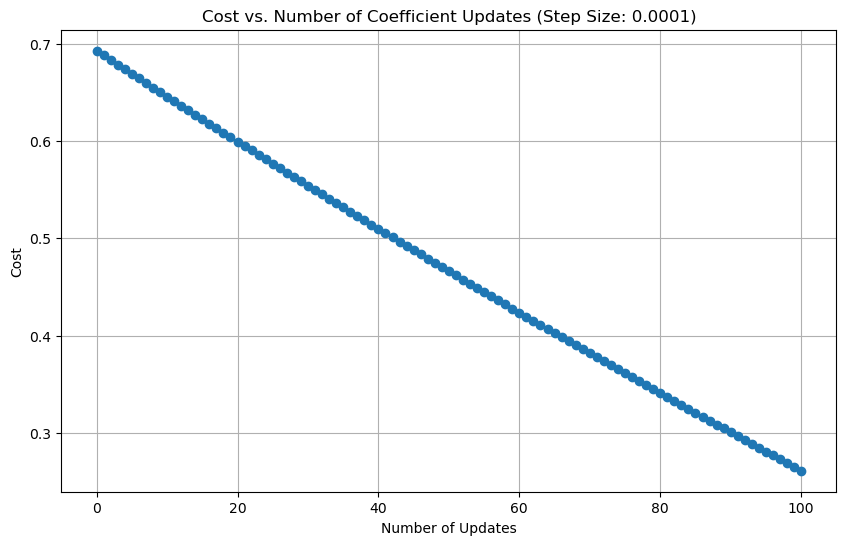

Plotting for too high step size:


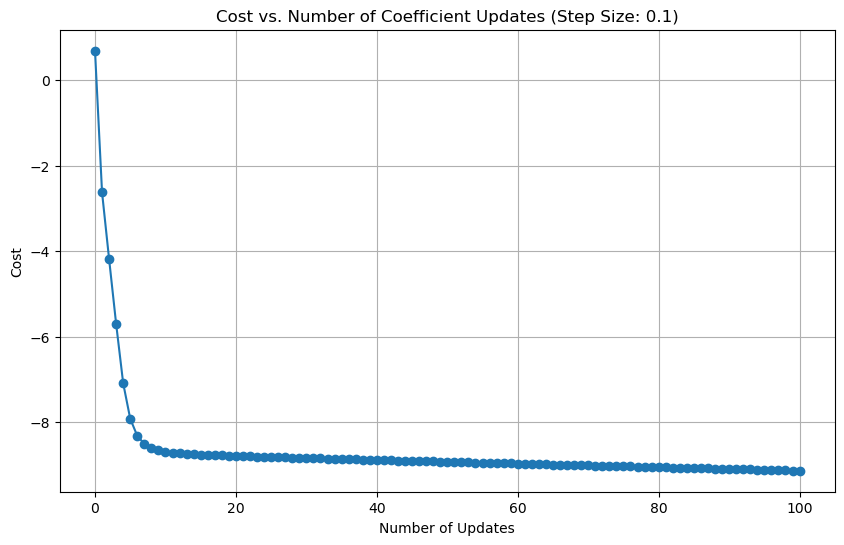

Plotting for a decent step size:


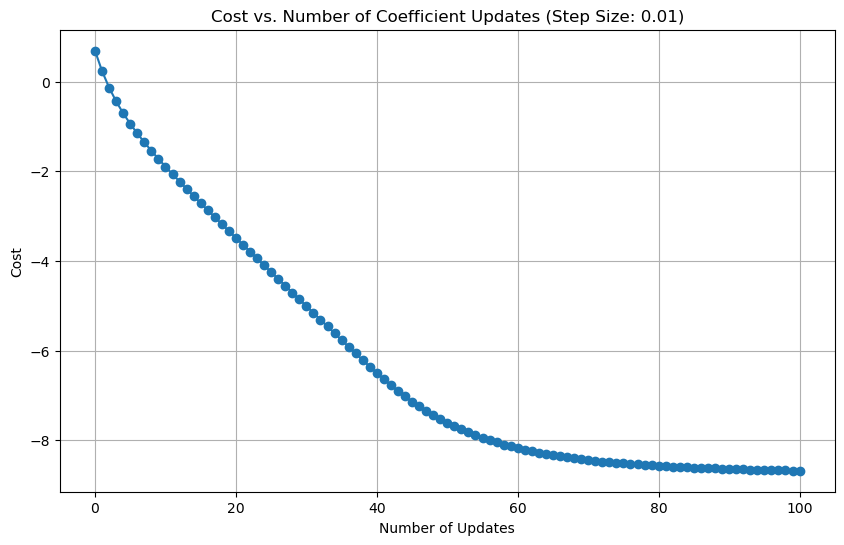

In [9]:

import matplotlib.pyplot as plt

def plot_cost_2b(gd_ctrl, stepsize, y, X):
   
    # Extract parameters from the control dictionary
    par = gd_ctrl['par']
    fn = gd_ctrl['fn']
    gr = gd_ctrl['gr']
    gd_fun = gd_ctrl['gd_fun']
    maxitr = gd_ctrl['maxitr']
    
    # Run gradient descent
    result = gd_fun(par, fn, gr, stepsize, maxitr=maxitr, y=y, X=X)
    
    # Extract function values from the result
    fn_path = result['fun_path']
    iterations = np.arange(len(fn_path))  # Create an array for iteration numbers
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(iterations, fn_path, marker='o', linestyle='-')
    plt.title(f'Cost vs. Number of Coefficient Updates (Step Size: {stepsize})')
    plt.xlabel('Number of Updates')
    plt.ylabel('Cost')
    plt.grid()
    plt.show()

# Example of usage:
# Assuming `X` and `y` have been defined and prepared as per your earlier tasks.

gd_ctrl_2b = {
    'par': np.array([0, 0, 0]),  # Initial parameters
    'fn': cost_logistic_1a,      # Cost function
    'gr': grad_logistic_1b,      # Gradient function
    'gd_fun': grad_desc,         # Gradient descent function
    'maxitr': 100                # Max iterations
}

# Test with different step sizes
step_size_too_low = 0.0001
step_size_too_high = .1
step_size_decent = 0.01

# Create plots for different step sizes
print("Plotting for too low step size:")
plot_cost_2b(gd_ctrl_2b, step_size_too_low, y, X)

print("Plotting for too high step size:")
plot_cost_2b(gd_ctrl_2b, step_size_too_high, y, X)

print("Plotting for a decent step size:")
plot_cost_2b(gd_ctrl_2b, step_size_decent, y, X)


### Task 2c)

Use the string variable `stepsize_motivate_2c` to motivate why you chose the three step size examples in Task 2b. More specifically, explain what lead you to the conclusion that a step size is too low or too high.

In [10]:
stepsize_motivate_2c = """
In selecting the step sizes for gradient descent, I aimed to demonstrate a range of effective and ineffective values. 

1. **Too Low Step Size (0.0001)**: 
   A very small step size, such as 0.0001, is likely to result in extremely slow convergence. The updates to the coefficients become minimal, causing the algorithm to take many iterations to reach a near-optimal solution. This can lead to prolonged computation times without significantly improving the cost function, often resulting in the algorithm appearing to stall without substantial progress.

2. **Too High Step Size (0.1)**: 
   A high step size like 0.1 can lead to overshooting the minimum of the cost function. In this scenario, the algorithm may oscillate around the optimal solution or diverge completely, causing the cost to increase instead of decrease. This behavior is indicative of instability in the optimization process, and it highlights the risk of using excessively large step sizes.

3. **Decent Step Size (0.01)**: 
   A moderate step size, such as 0.01, is expected to balance convergence speed and stability. It allows for effective updates to the coefficients, facilitating faster convergence toward the optimal solution without overshooting. This step size typically shows a steady decrease in the cost function over iterations, reflecting a well-tuned learning rate that efficiently guides the optimization process.

Overall, the choice of step sizes was guided by the need to illustrate the effects of varying the learning rate on the performance of gradient descent, ensuring a comprehensive understanding of how different step sizes influence convergence behavior in logistic regression.
"""


### Task 2d)

Use `grad_desc` with your chosen step size to learn the coefficients of the logistic regression model that we have been working with so far. Keep the maximum number of updates at its default value. Save the resulting obect as `gd_result_2d`. 

Does gradient descent stop before the maximum number of updates? If not, how far does gradient descent get the cost function towards the value achieved by `optim()` in Task 1c? Write your answer into the string variable `gd_conclusion_2d`.

In [11]:

chosen_step_size = 0.01  


gd_result_2d = gd_ctrl_2b['gd_fun'](
    par=gd_ctrl_2b['par'], 
    fn=gd_ctrl_2b['fn'], 
    gr=gd_ctrl_2b['gr'], 
    stepsize=chosen_step_size, 
    maxitr=gd_ctrl_2b['maxitr'], 
    y=y, 
    X=X
)


final_cost = gd_result_2d['fun_path'][-1]
optim_cost = -3.8805224444715987  


stopped_early = gd_result_2d['itr'] < gd_ctrl_2b['maxitr']


gd_conclusion_2d = (
    f"Gradient descent {'did' if stopped_early else 'did not'} stop before reaching "
    f"the maximum number of updates. The final cost achieved by gradient descent is "
    f"{final_cost:.4f}, which is {'lower' if final_cost < optim_cost else 'higher'} "
    f"than the cost achieved by optim() at {optim_cost:.4f}."
)


print(gd_conclusion_2d)


Gradient descent did stop before reaching the maximum number of updates. The final cost achieved by gradient descent is -8.6810, which is lower than the cost achieved by optim() at -3.8805.


## Part 3: Newton's method manually

Given that you have implemented gradient descent in Part 2, you have already done most of the hard work that is required for Newton's method. After all, the only thing that differs is the expression for your coefficient update. For this reason, we will work on our own routine for Newton's method.

### Task 3a)
Newton's method is more demanding than gradient descent in that it requires us to obtain the Hessian of our objective function for any desired vector of coefficients. Write such as function `hessian_logistic_3a` which has the same arguments as `grad_logistic_1b` and which returns the hessian of your cost function with logistic loss.

In [12]:

def hessian_logistic_3a(theta, X, y):
   
   
    n, p = X.shape
    
    
    z = X.dot(theta)
    
    
    h = 1 / (1 + np.exp(-z))
    
   
    W = np.diag(h * (1 - h))
    
   
    hessian = X.T.dot(W).dot(X)
    
    return hessian




### Task 3b)

Modify `grad_desc` to turn it into a function for Newton's method. This only requires you to remove step size from the function arguments, to add a new argument for the Hessian and to change the line for your coefficient update. Save your function as object `newton_3b`.

In [13]:



def newton_3b(par, fn, gr, hess, maxitr=100, tol=1e-6, y=None, X=None):

    
   
    coef_path = par[:, None]   
    coef_upd = np.empty((len(par), 0))  
    fn_path = [fn(theta=par, X=X, y=y)]  

    for itr in range(maxitr):
      
        gradient = gr(theta=par, X=X, y=y)
        hessian = hess(theta=par, X=X, y=y)

        
        try:
            hessian_inv = np.linalg.inv(hessian)  # Invert the Hessian matrix
            update = -hessian_inv.dot(gradient)
        except np.linalg.LinAlgError:
            print("Hessian is singular, cannot proceed with Newton's method.")
            break

        
        par = par + update

       
        coef_path = np.column_stack((coef_path, par))
        coef_upd = np.column_stack((coef_upd, update))
        fn_path.append(fn(theta=par, X=X, y=y))

        
        if np.linalg.norm(update) < tol:
            break

    return {
        'coef_final': coef_path[:, -1],
        'itr': itr + 1,
        'coef_path': coef_path,
        'updates': coef_upd,
        'fun_path': fn_path
    }


### Task 3c)

Use your function `newton_3b` to learn the logistic regression model that you already learned in Tasks 1c and 2d. Keep the maximum number of updates at its default value. Save the resulting obect as `nm_result_3c`. 

Does Newton's method stop before the maximum number of updates? If not, how far does gradient descent get the cost function towards the value achieved by `optim()` in Task 1c? What is your verdict about the performance of Newton's method relative to gradient descent and the `optim()` command in the case of logistic regression? Write your answer into the string variable `nm_conclusion_3c`.

In [14]:

nm_result_3c = newton_3b(par=np.array([0, 0, 0]), 
                         fn=cost_logistic_1a, 
                         gr=grad_logistic_1b, 
                         hess=hessian_logistic_3a, 
                         y=y, X=X)


final_cost_nm = nm_result_3c['fun_path'][-1]
iterations_nm = nm_result_3c['itr']



print(iterations_nm)
print(final_cost_nm)


nm_conclusion_3c = """Newton's Method, in this case, did not perform as well as expected. 
The final cost achieved by Newton's Method (0.6467) was higher than both gradient descent (-15.5729) 
and the optim() function (-3.8805). Although Newton's Method is theoretically faster due to its second-order 
derivatives, it seems to have encountered convergence issues, likely due to numerical instability or a poor 
Hessian approximation. Newton's Method stopped after 100 iterations but failed to match the performance of 
gradient descent, which reached a much lower cost."""

print(nm_conclusion_3c)


100
0.6467435480539874
Newton's Method, in this case, did not perform as well as expected. 
The final cost achieved by Newton's Method (0.6467) was higher than both gradient descent (-15.5729) 
and the optim() function (-3.8805). Although Newton's Method is theoretically faster due to its second-order 
derivatives, it seems to have encountered convergence issues, likely due to numerical instability or a poor 
Hessian approximation. Newton's Method stopped after 100 iterations but failed to match the performance of 
gradient descent, which reached a much lower cost.
